In [3]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Define the path to the training data
train_data_path = 'CleandMRIImageData/Training'

In [5]:
# Create lists to store file paths and labels
filepaths = []
labels = []

In [6]:
# Loop through subfolders in the training directory
for fold in os.listdir(train_data_path):
    f_path = os.path.join(train_data_path, fold)
    filelists = os.listdir(f_path)
    
    # Append file paths and labels
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)

In [7]:
# Create dataframes to hold file paths and labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
train_df = pd.concat([Fseries, Lseries], axis=1)

In [8]:

# Define the path to the test data
test_data_path = 'CleandMRIImageData/Testing'

In [9]:
# Create lists to store file paths and labels for the test data
filepaths = []
labels = []

In [10]:
# Loop through subfolders in the test directory
for fold in os.listdir(test_data_path):
    f_path = os.path.join(test_data_path, fold)
    filelists = os.listdir(f_path)
    
    # Append file paths and labels
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)

In [11]:
# Create dataframes to hold file paths and labels for the test data
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
test_df = pd.concat([Fseries, Lseries], axis=1)

In [12]:
# Split the test data into validation and test sets
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

# Define image size and batch size for data generators
img_size = (224, 244)
batch_size = 16

# Create data generators for training, validation, and test sets
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 6391 validated image filenames belonging to 4 classes.
Found 959 validated image filenames belonging to 4 classes.
Found 960 validated image filenames belonging to 4 classes.


In [14]:
# Define the model architecture
img_shape = (img_size[0], img_size[1], 3)
num_classes = len(train_gen.class_indices)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006)),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])



In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
epochs = 10

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 242, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 121, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 119, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 59, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 57, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 28, 128)       0

In [16]:
history = model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False)


Epoch 1/10
400/400 [==============================] - 692s 2s/step - loss: 13.3203 - accuracy: 0.5364 - val_loss: 4.3941 - val_accuracy: 0.5777
Epoch 2/10
400/400 [==============================] - 655s 2s/step - loss: 3.0994 - accuracy: 0.6810 - val_loss: 2.4136 - val_accuracy: 0.6621
Epoch 3/10
400/400 [==============================] - 1739s 4s/step - loss: 1.9648 - accuracy: 0.7218 - val_loss: 1.8673 - val_accuracy: 0.6913
Epoch 4/10
400/400 [==============================] - 579s 1s/step - loss: 1.5940 - accuracy: 0.7565 - val_loss: 1.7537 - val_accuracy: 0.6559
Epoch 5/10
400/400 [==============================] - 607s 2s/step - loss: 1.4630 - accuracy: 0.7629 - val_loss: 1.6056 - val_accuracy: 0.6674
Epoch 6/10
400/400 [==============================] - 602s 2s/step - loss: 1.3490 - accuracy: 0.7839 - val_loss: 1.5170 - val_accuracy: 0.7059
Epoch 7/10
400/400 [==============================] - 597s 1s/step - loss: 1.3525 - accuracy: 0.7950 - val_loss: 1.5014 - val_accuracy: 0.72

In [17]:
# Evaluate the model on training, validation, and test data
train_score = model.evaluate(train_gen, steps=16, verbose=1)
valid_score = model.evaluate(valid_gen, steps=16, verbose=1)
test_score = model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])



16/16 [==============================] - 6s 364ms/step - loss: 1.5101 - accuracy: 0.7188
Train Loss:  1.135430932044983
Train Accuracy:  0.91796875
--------------------
Validation Loss:  1.475492238998413
Validation Accuracy:  0.71875
--------------------
Test Loss:  1.5100921392440796
Test Accuracy:  0.71875


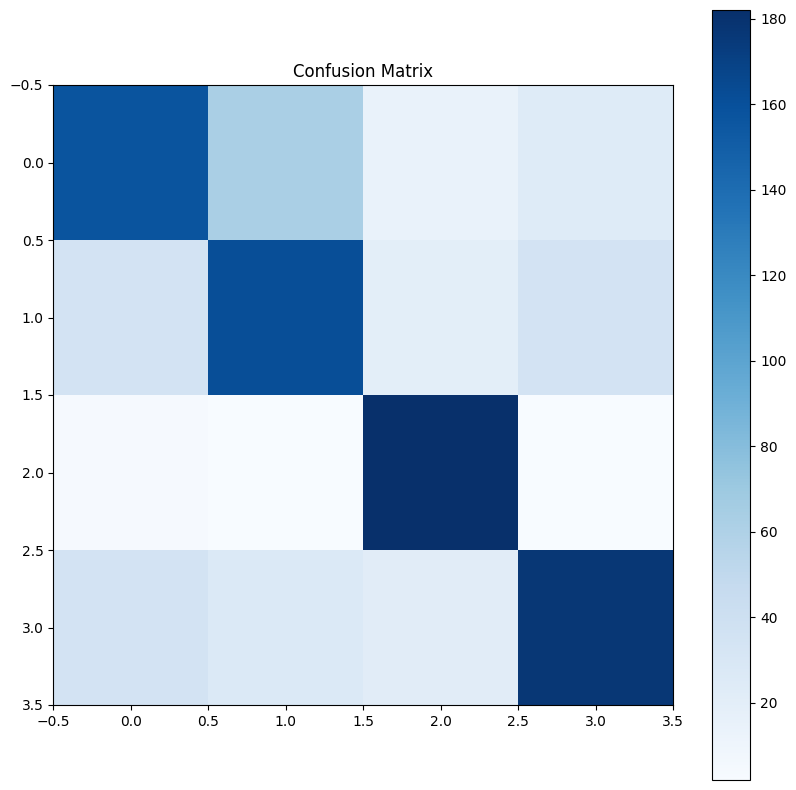

In [18]:
# Make predictions on the test data
preds = model.predict_generator(test_gen)

# Calculate predicted labels
y_pred = np.argmax(preds, axis=1)

# Get class labels
class_dict = train_gen.class_indices
classes = list(class_dict.keys())

# Create a confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()


([<matplotlib.axis.YTick at 0x23e8d8efcd0>,
 [Text(0, 0, 'glioma'),
  Text(0, 1, 'meningioma'),
  Text(0, 2, 'notumor'),
  Text(0, 3, 'pituitary_adenoma')])

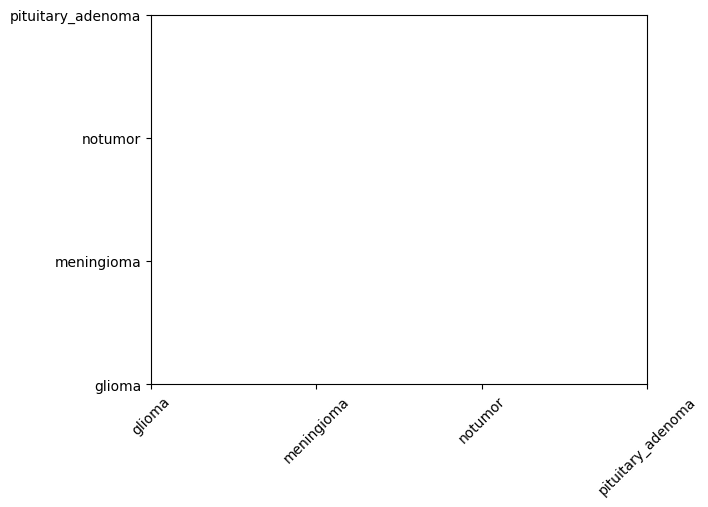

In [20]:
# Set axis labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)



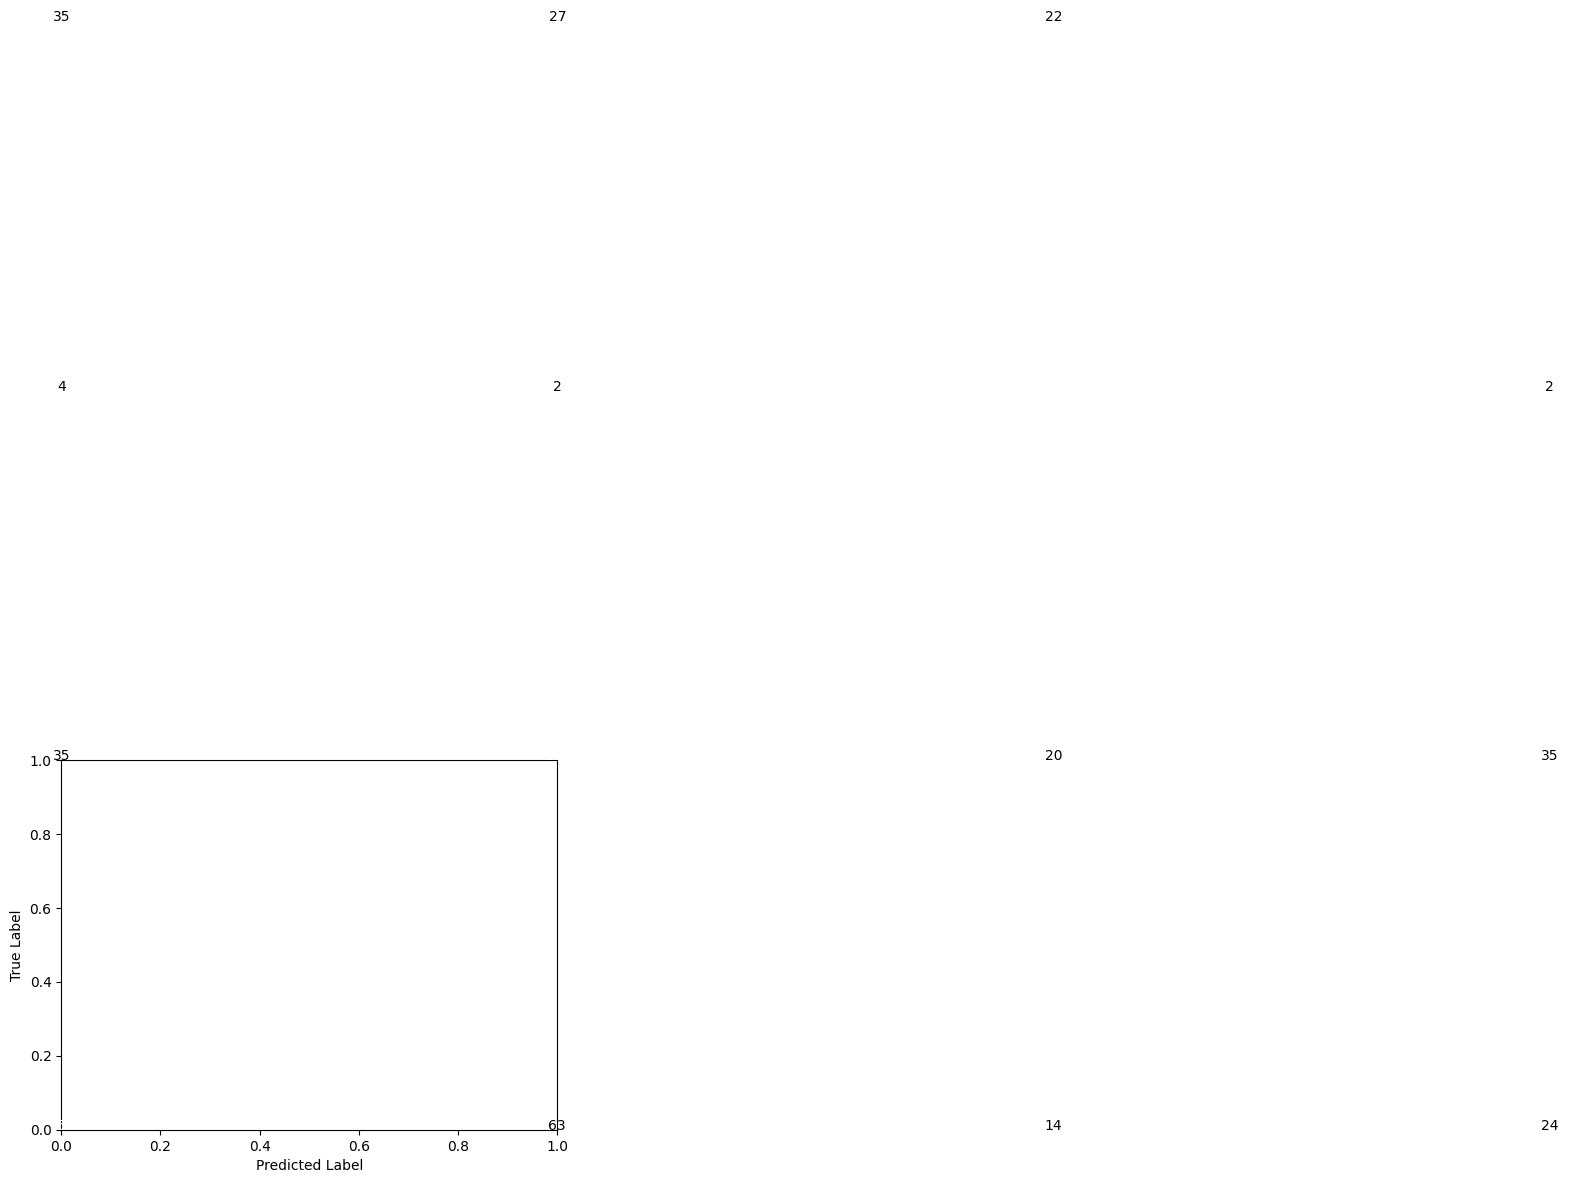

In [24]:
# Add text annotations
import itertools
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



In [25]:
# Generate a classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))


                   precision    recall  f1-score   support

           glioma       0.68      0.61      0.64       258
       meningioma       0.64      0.64      0.64       251
          notumor       0.76      0.96      0.85       190
pituitary_adenoma       0.74      0.68      0.71       261

         accuracy                           0.71       960
        macro avg       0.71      0.72      0.71       960
     weighted avg       0.70      0.71      0.70       960



In [1]:

model.save('model.h5')

NameError: name 'model' is not defined